In [154]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import numpy as np


from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# Aesthetic parameters for plots
plt.rcParams["font.family"] = "serif"
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown']
x_min = 0
x_max = 1000

In [155]:
fs = 2000

# Channel: 0 or 1
# Returns numpy array of size (40001).
def load_data(channel, plot=False):
    M = np.loadtxt("EMG_example_20s_2000Hz-2022.csv", delimiter=",", dtype=float) # read csv

    raw_data = M[:, channel]
    print(f'Loaded raw data of channel {channel}, size {raw_data.shape}, sampling rate {fs} Hz.')

    if plot:
        plt.plot(raw_data, color='blue')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.xlim(x_min, x_max)
        plt.title('Raw Data')
        plt.figure()
    
    return raw_data

# Applies a Butterworth filter from low_freq to high_freq.
# Returns the filtered data.
def bandpass_filter(data, low_freq, high_freq, sampling_rate, steepness = 3, plot=False):

    sos = sig.butter(steepness, [low_freq * 2/sampling_rate, high_freq * 2/sampling_rate], btype = "bandpass", output = "sos")
    filt_data = sig.sosfilt(sos, data)

    print(f'Applied bandpass filter from {low_freq} Hz to {high_freq} Hz.')

    if plot:
        plt.plot(filt_data, color='blue')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.xlim(x_min, x_max)
        plt.title('Filtered Data')
        plt.figure()
        
    return filt_data

# Applies a highpass Butterworth filter from low_freq above.
# Returns the filtered data.
def highpass_filter(data, low_freq, sampling_rate, steepness = 3, plot=False):

    sos = sig.butter(steepness, low_freq*2/sampling_rate, btype='highpass', output='sos')
    filt_data = sig.sosfilt(sos, data)

    print(f'Applied highpass filter from {low_freq} Hz.')

    if plot:
        plt.plot(filt_data, color='blue')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.xlim(x_min, x_max)
        plt.title('Filtered Data')
        plt.figure()
        
    return filt_data

# Applies the nonlinear energy operator to the given data.
# Returns the NEO data.
# Appends zeros to the beginning and end to maintain the same length as the raw data to preserve index fidelity.
def NEO(data, plot=False):
    neo_arr = []
    neo_arr.append(0)
    
    for i in range(1, len(data) - 1):
        neo_i = data[i]**2 - data[i-1]*data[i+1]  # x(t)x(t) - x(t-1)x(t+1)
        neo_arr.append(neo_i)
    
    neo_arr.append(0)

    print('Applied NEO to data.')

    if plot:
        plt.plot(neo_arr, color='green')
        plt.xlabel('Sample')
        plt.xlim(x_min, x_max)
        plt.ylim(-0.2, 0.5)
        plt.ylabel('Amplitude')
        plt.title('NEO Data')
        plt.figure()

    return neo_arr

# Finds an amplitude threshold for NEO, which is used to select spikes.
# Selects spikes of amplitudes that are 3% as common as the most common amplitudes.
# Returns the threshold.
def find_neo_amplitude_threshold(neo_arr, plot=False):
    frequency, bins = np.histogram(neo_arr, bins=1000)

    
    max_val = np.max(frequency)
    t = bins[np.where(frequency <= 0.03*max_val)]
    threshold = t[np.where(t > 0)][0]
    if plot:
        plt.plot(bins[1:], frequency, label='NEO data histogram', color='brown')
        plt.xlim(0, 0.1)
        plt.axvline(x = threshold, label='Threshold', color='blue')
        plt.legend()
        plt.title('Threshold Selection')
        plt.xlabel('NEO Amplitude')
        plt.ylabel('Frequency')
        plt.figure()

    print(f'Found a NEO amplitude threshold of {threshold:.2E}.')
    return threshold

# Returns the indices of the NEO array that correspond to spikes.
# First finds all the indices that pass a certain amplitude threshold (threshold_indices).
# Second, finds all the indices that are not preceded by another spike by length spike_length (spike_starts).
# Third, finds the spike peaks by finding the local maximum of spike_starts (spike_peaks).
# Returns spike peaks.
def get_spike_peaks(neo_arr, threshold, spike_length, plot=False):
    threshold_indices = np.where(neo_arr >= threshold)[0] # Find all data points that surpass threshold

    # This script finds the indices of the beginning of each spike. It includes most of the threshold indices
    # while excluding some of the indices that fall within one spike length of an index.
    spike_starts = [threshold_indices[0]]
    for i in range(1, len(threshold_indices)):
        spike_time = threshold_indices[i]
        if spike_time - spike_starts[-1] > spike_length:
            spike_starts.append(spike_time)

    # This script finds the peaks of each spike. Within a radius of one spike length, it finds the peak of the data.
    spike_peaks = []
    for i in range(0, len(spike_starts)):
        spike_start = spike_starts[i]
        spike_max = spike_start + np.argmax(neo_arr[spike_start: spike_start+spike_length])
        spike_min = spike_start + np.argmin(neo_arr[spike_start: spike_start+spike_length])
        if neo_arr[spike_max] > np.abs(neo_arr[spike_min]):
            spike_peaks.append(spike_max)
        else:
            spike_peaks.append(spike_min)

    print(f'Found {len(spike_peaks)} spike peaks using NEO.')

    if plot:
        plt.plot(neo_arr, label='NEO', color='green')
        for i in range(len(spike_peaks)):
            x = spike_peaks[i]
            y = neo_arr[x]
            plt.scatter(x, y, color='red', alpha=0.5)
        plt.axhline(y = threshold, color='r', linestyle='-', alpha=0.2, label='Threshold ('+str(threshold) + ')')
        plt.xlim(x_min, x_max)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.ylim(-0.02, 0.05)
        plt.title('Spikes Identified Using NEO (Delay: ' + str(spike_length) + ' ms)')
        plt.legend()
        plt.figure()
        
    return spike_peaks


# Stacks all spikes into a matrix.
# Given spike peaks, acquires a window around each peak.
# Returns the matrix of aligned spikes of size (len(spike_peaks), left_window + right_window).
def align_spikes(spike_peaks, filt_data, left_window, right_window, plot=False):
    matrix = []

    for i in range(len(spike_peaks)):
        spike_idx = spike_peaks[i]
        chunk = filt_data[spike_idx-left_window:spike_idx+right_window]
    
        # If the chunk is too short, add zeros.
        while len(chunk) < right_window + left_window:
            chunk = np.append(chunk, 0)
        matrix.append(chunk)
        if plot:
            plt.plot(chunk, alpha=0.04)

    if plot:
        plt.title('Spike Alignment (Filtered Data)')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.figure()

    
    matrix = np.array(matrix)
    print(f'Aligned spikes into a matrix of shape {matrix.shape}.')

    return matrix

# Uses PCA to compress a matrix of aligned spikes into 2 dimensions.
# Uses 2 dimensions for clustering to work.
# Returns the compressed matrix of size (len(spike_peaks), 2).
def compress_aligned_spikes(matrix, n_components, plot=False):
    pca = PCA(n_components=n_components)
    compressed_matrix = pca.fit_transform(matrix, y=None)

    if plot:
        a, b = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
        plt.scatter(compressed_matrix[:, 0], compressed_matrix[:, 1], color='pink', marker='+')
        plt.title('PCA Compression of Spike Data')
        plt.xlabel(f'Component 1: {a*100:.3}%')
        plt.ylabel(f'Component 2: {b*100:.3}%')
        plt.figure()
    
    print(f'Compressed data into {n_components} dimensions that explain {100*np.sum(pca.explained_variance_ratio_):.3}% of the variance.')
    return compressed_matrix

# Finds the best number of clusters (K) for agglomerative clustering.
# First, creates a dendrogram.
# Then, finds the largest distance difference between two clusters.
# Then, finds the largest value of K for which the distance is within 80% of the largest. That is considered the best K.
#    This is to bias the algorithm on the side of more clusters.
# Returns the best K value.
def get_best_K_agg_cluster(compressed_matrix, plot=False):
    Sum_of_squared_distances = []
    percent_drops = []
    
    agg_cluster = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0)
    agg_cluster.fit(compressed_matrix)
    
    linkage_matrix = linkage(compressed_matrix, method='ward')
    dendrogram_data = dendrogram(linkage_matrix, truncate_mode='level', p=5, no_plot=not plot)  # Adjust the 'p' parameter for a clear view

    y_values = np.array(dendrogram_data['dcoord'])[:, 1]
    y_distances = np.diff(y_values)[::-1]
    peak = np.argmax(y_distances)

    max_K = 8
    # Finds the largest k value where the y value is within 20% of the peak.
    best_K = np.where(y_distances[:max_K] >= 0.2*np.max(y_values))[0][-1] + 2 # Add two because the function starts at 2 clusters, not 0.

    if plot:
        plt.figure()
        plt.plot(y_distances, color='magenta')
        plt.xlabel('Cluster')
        plt.ylabel('Cluster Distance')
        plt.title('Best K')
        plt.scatter(best_K-2, y_distances[best_K-2], color='cyan')
        plt.figure()

        
    print(f'Found an optimal K of {best_K} for agglomerative clustering.')

    return best_K

# Given the 2D matrix and K, performs agglomerative clustering.
# Returns the agglomerative clustering object.
def cluster_spikes(compressed_matrix, K, plot=False):
    agg_cluster = AgglomerativeClustering(n_clusters=K, linkage='ward', metric='euclidean')
    agg_cluster.fit(compressed_matrix)
    print(f'Grouped data into {K} clusters.')

    if plot:
        plt.figure()
        
        for i in range(len(compressed_matrix)):
            plt.scatter(compressed_matrix[i, 0], compressed_matrix[i, 1], color=colors[agg_cluster.labels_[i]], s=50, edgecolors='k', linewidth=0.5)
        plt.title('Agglomerative Clustering of PCA Data')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.figure()
    return agg_cluster


# Plots the aligned spikes, color-coded by class.
def visualize_results_alignment(filt_data, spike_peaks, agg_cluster, left_window, right_window, plot_avg=False):
    
    avg_chunks = [[] for _ in range(5)]
    
    for i in range(len(spike_peaks)):
        spike_idx = spike_peaks[i]
        chunk = filt_data[spike_idx-left_window:spike_idx+right_window]
        while len(chunk) < right_window + left_window:
            chunk = np.append(chunk, 0)
        label_idx = agg_cluster.labels_[i]
        avg_chunks[label_idx].append(chunk)
        plt.plot(chunk, alpha=0.08, color=colors[label_idx])
           
    if plot_avg:
        for i in range(len(avg_chunks)):
           plt.plot(np.mean(avg_chunks[i], axis=0), color=colors[i], linewidth=3, alpha=0.7)
    
    plt.title('Aligned Spikes After Classification')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.figure()


# Plots the raw data with spikes labeled by class.
def visualize_results_raw(raw_data, spike_peaks, agg_cluster):
    
    plt.plot(raw_data, color='pink', alpha=0.5)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.xlim(x_min, x_max)
    plt.title('Raw Data with Class Labels')
    
    
    for i in range(len(spike_peaks)):
        color = colors[agg_cluster.labels_[i]]
        raw_spike_peak = np.argmax(raw_data[spike_peaks[i]-10:spike_peaks[i]+10]) - 10 + spike_peaks[i]
        plt.scatter(raw_spike_peak, raw_data[raw_spike_peak], c=color)

    plt.figure()


In [156]:

### Parameters

# a. Input file
CHANNEL = 1 # Which channel to load from

# b. Filter signal
LOW_FREQ = 100 # Low frequency in bandpass filter
HIGH_FREQ = 999 # High frequency in bandpass filter

# c. Detect Spikes
SPIKE_LENGTH = 20 # Minimum delay allowed between spikes 

# d. Align Spikes
LEFT_WINDOW = 5 # Number of data points to the left of the peak to include
RIGHT_WINDOW = 15 # Number of data points to the right of the peak to include

# e. Extract Features
N_COMPONENTS = 2


def pipeline(channel):
    raw_data = load_data(channel)
    filt_data = bandpass_filter(raw_data, LOW_FREQ, HIGH_FREQ, sampling_rate=fs)
    neo_data = np.array(NEO(filt_data, plot=True))
    neo_threshold = find_neo_amplitude_threshold(neo_data, plot=True)

    
    spike_peaks = get_spike_peaks(neo_data, neo_threshold, SPIKE_LENGTH)
    matrix = align_spikes(spike_peaks, filt_data, LEFT_WINDOW, RIGHT_WINDOW, True)
    
    compressed_matrix = compress_aligned_spikes(matrix, N_COMPONENTS, True)
    best_K = get_best_K_agg_cluster(compressed_matrix, True)
    agg_cluster = cluster_spikes(compressed_matrix, best_K, True)
    class_labels = agg_cluster.labels_
    
    visualize_results_alignment(filt_data, spike_peaks, agg_cluster, LEFT_WINDOW, RIGHT_WINDOW, plot_avg=True)
    visualize_results_raw(raw_data, spike_peaks, agg_cluster)
    


# Channel 1 (Test)

Loaded raw data of channel 0, size (40001,), sampling rate 2000 Hz.
Applied bandpass filter from 100 Hz to 999 Hz.
Applied NEO to data.
Found a NEO amplitude threshold of 7.22E-02.
Found 653 spike peaks using NEO.
Aligned spikes into a matrix of shape (653, 20).
Compressed data into 2 dimensions that explain 67.0% of the variance.
Found an optimal K of 5 for agglomerative clustering.
Grouped data into 5 clusters.


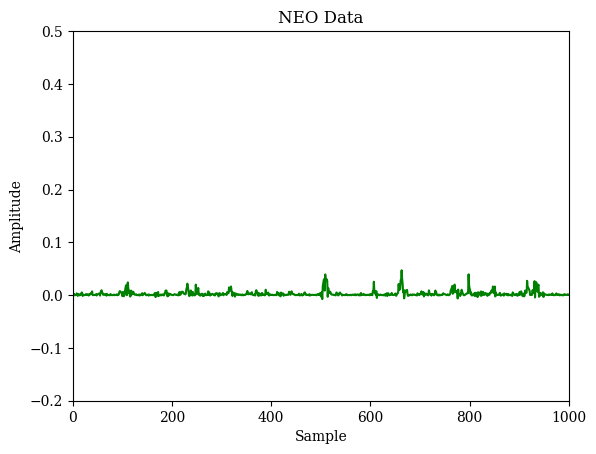

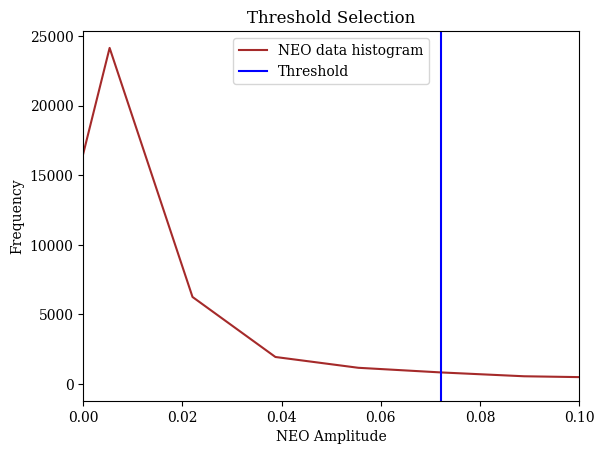

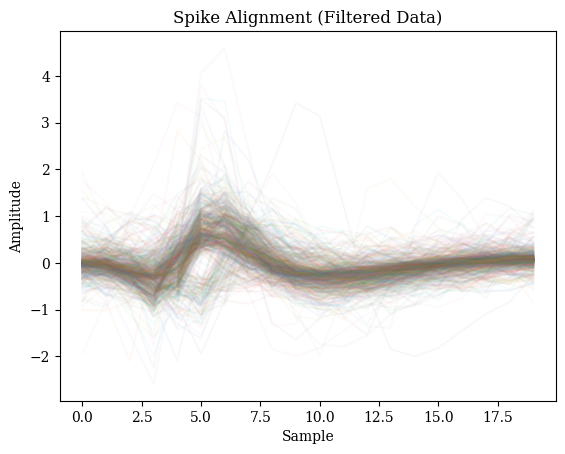

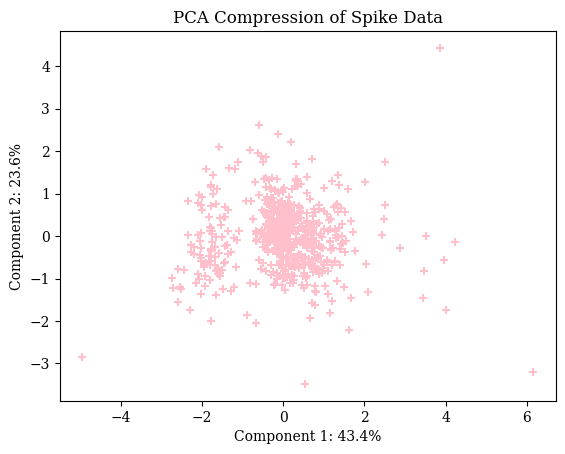

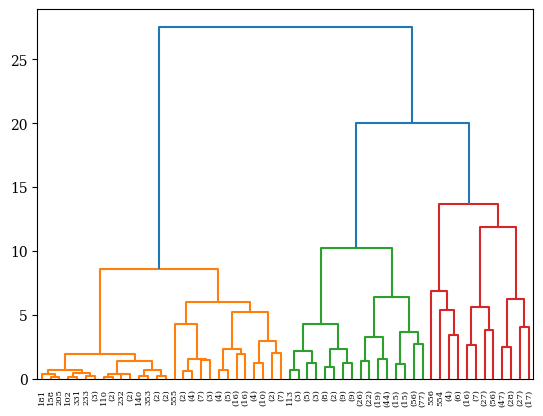

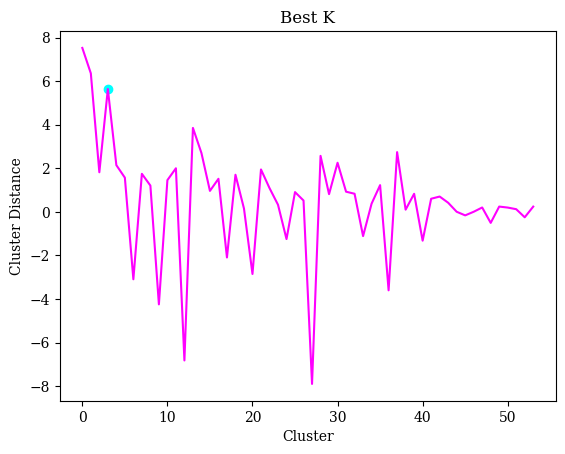

<Figure size 640x480 with 0 Axes>

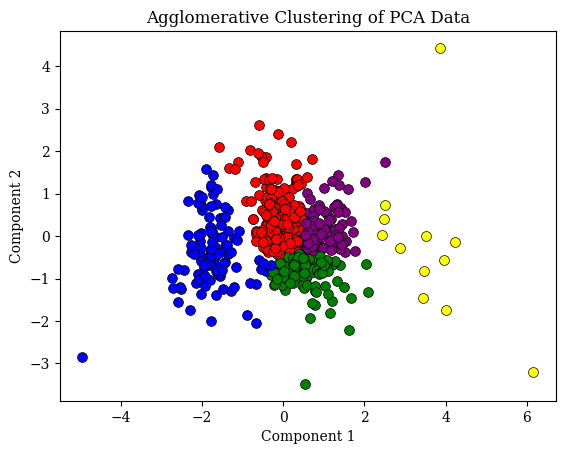

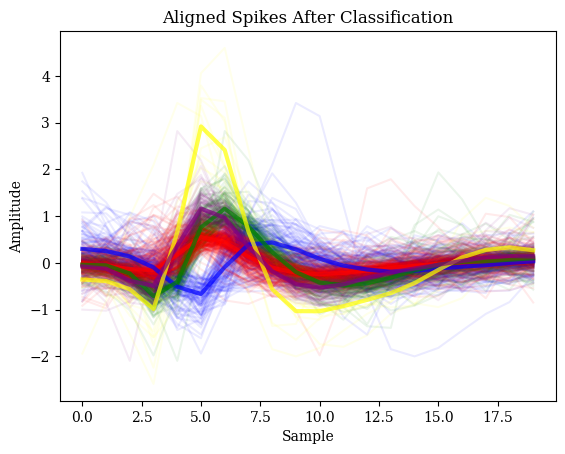

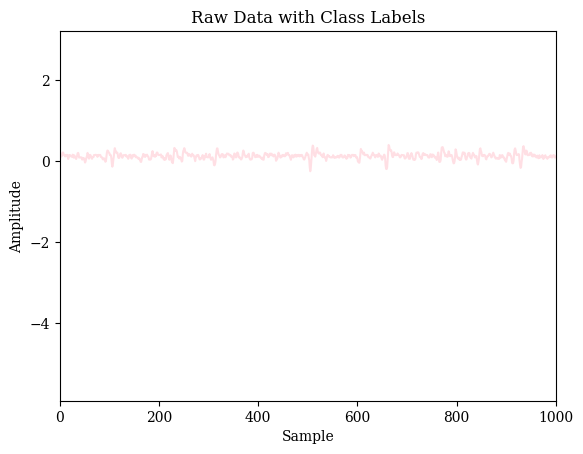

<Figure size 640x480 with 0 Axes>

In [157]:
pipeline(0)

The red, green, and purple waveforms are clearly the same, indicating that the k value chosen was too large. The yellow waveform could be its own MUAP or outliers of another one. The raw data shows what are likely to be spikes that have not been classified because the threshold was too low.

# Channel 2 (Train)

Loaded raw data of channel 1, size (40001,), sampling rate 2000 Hz.
Applied bandpass filter from 100 Hz to 999 Hz.
Applied NEO to data.
Found a NEO amplitude threshold of 7.16E-03.
Found 641 spike peaks using NEO.
Aligned spikes into a matrix of shape (641, 20).
Compressed data into 2 dimensions that explain 71.2% of the variance.
Found an optimal K of 4 for agglomerative clustering.
Grouped data into 4 clusters.


/Users/martinbourdev/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/martinbourdev/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


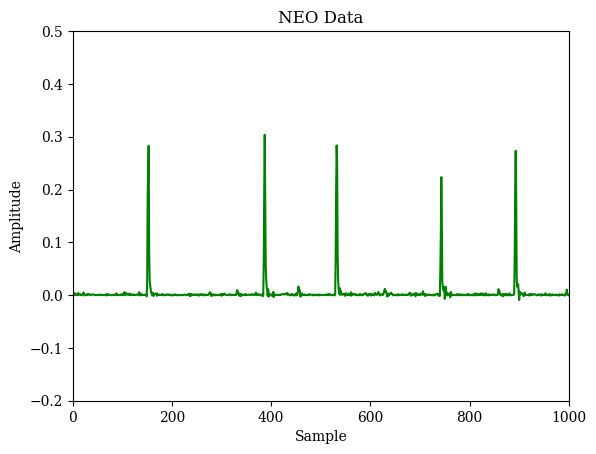

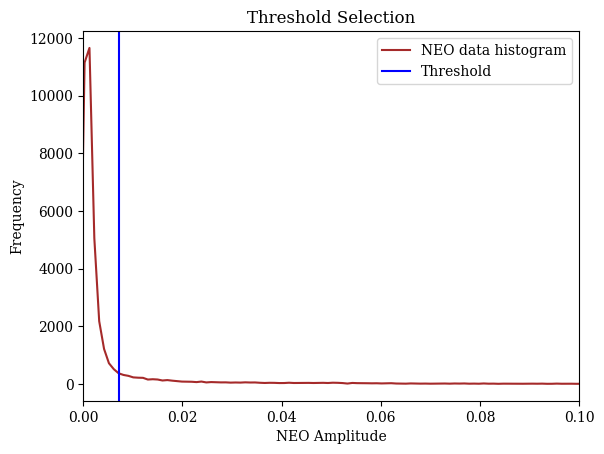

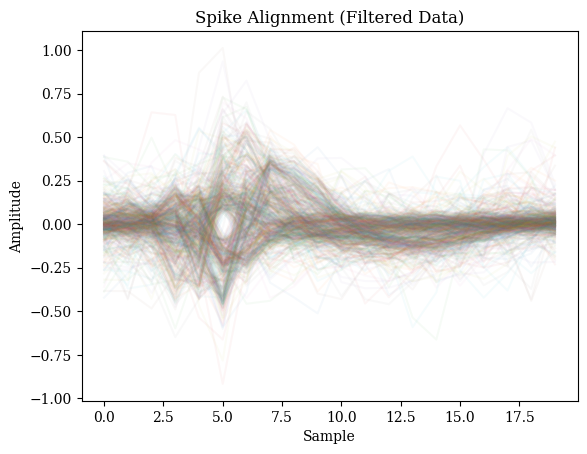

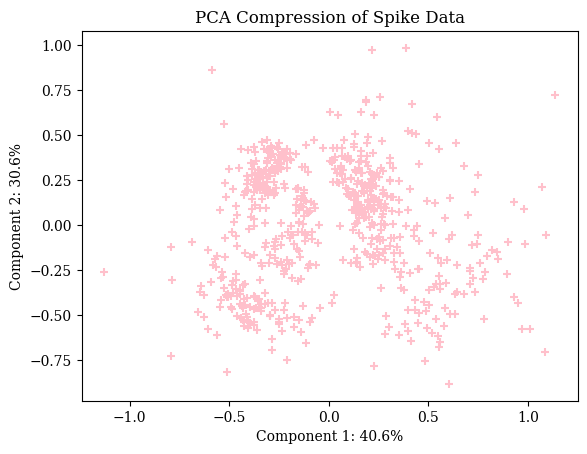

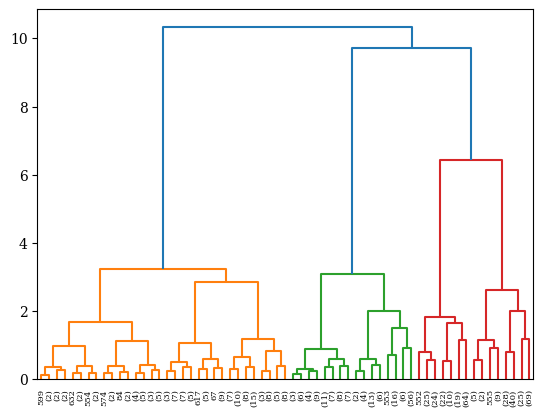

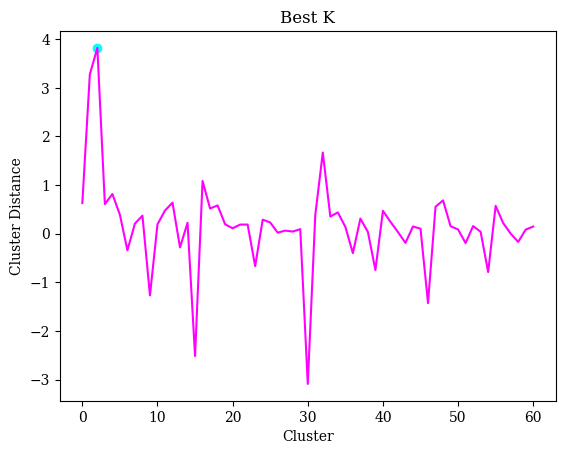

<Figure size 640x480 with 0 Axes>

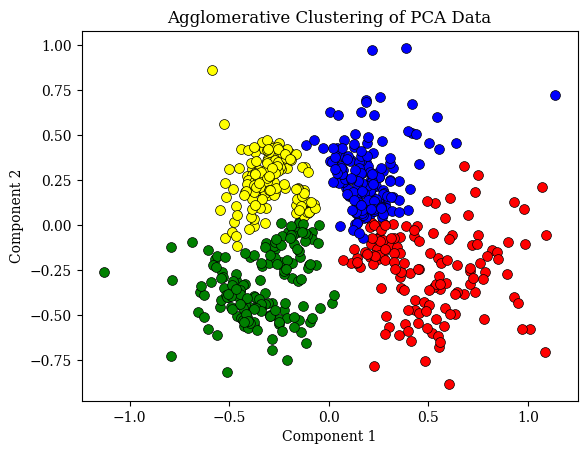

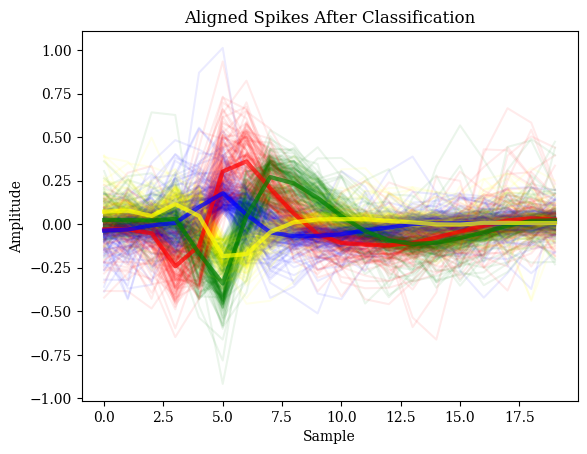

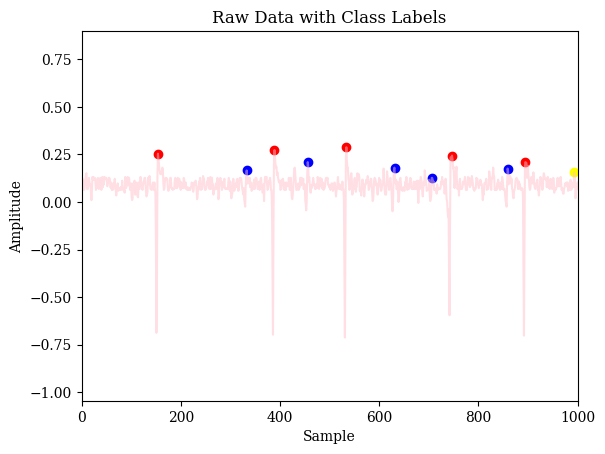

<Figure size 640x480 with 0 Axes>

In [158]:
pipeline(1)